In [1]:
from numpy import zeros, ones, expand_dims, asarray
from numpy.random import randn, randint
from keras.datasets.fashion_mnist import load_data
from keras.optimizers import Adam
from keras.models import Model, load_model
from keras.layers import Input, Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, LeakyReLU, BatchNormalization, Dropout, Embedding, Activation, Concatenate
from keras.initializers import RandomNormal
from matplotlib import pyplot
from math import sqrt

In [2]:
##### TRAIN FUNCS

#define discriminator model
def define_discriminator(in_shape=(28, 28, 1), n_classes = 10):
    #weight initialization
    init = RandomNormal(stddev=0.02)
    #image input
    in_image = Input(shape=in_shape)
    #downsample to 14x14
    fe = Conv2D(32, (3,3), strides=(2,2), padding="same", kernel_initializer=init)(in_image)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.5)(fe)
    #normal
    fe = Conv2D(64, (3,3), padding="same", kernel_initializer=init)(fe)
    fe = BatchNormalization()(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.5)(fe)
    #downsample to 7x7
    fe = Conv2D(128, (3,3), strides=(2,2), padding="same", kernel_initializer=init)(fe)
    fe = BatchNormalization()(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.5)(fe)
    # normal
    fe = Conv2D(256, (3,3), padding="same", kernel_initializer=init)(fe)
    fe = BatchNormalization()(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.5)(fe)
    # flatten feature maps
    fe = Flatten()(fe)
    # real/fake output
    out1 = Dense(1, activation="sigmoid")(fe)
    # class label output
    out2 = Dense(n_classes, activation="softmax")(fe)
    # define model
    model = Model(in_image, [out1, out2])
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss=["binary_crossentropy", "sparse_categorical_crossentropy"], optimizer=opt)
    return model

# define the standalone generator model
def define_generator(latent_dim, n_classes=10):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # label input
    in_label = Input(shape=(1,))
    # embedding for categorical input
    li = Embedding(n_classes, 50)(in_label)
    # linear multiplication
    n_nodes = 7 * 7
    li = Dense(n_nodes, kernel_initializer=init)(li)
    # reshape to additional channel
    li = Reshape((7, 7, 1))(li)
    # image generator input
    in_lat = Input(shape=(latent_dim,))
    # foundation for 7x7 image
    n_nodes = 384 * 7 * 7
    gen = Dense(n_nodes, kernel_initializer=init)(in_lat)
    gen = Activation("relu")(gen)
    gen = Reshape((7, 7, 384))(gen)
    # merge image gen and label input
    merge = Concatenate()([gen, li])
    # upsample to 14x14
    gen = Conv2DTranspose(192, (5,5), strides=(2,2), padding="same", kernel_initializer=init)(merge)
    gen = BatchNormalization()(gen)
    gen = Activation("relu")(gen)
    # upsample to 28x28
    gen = Conv2DTranspose(1, (5,5), strides=(2,2), padding="same", kernel_initializer=init)(gen)
    out_layer = Activation("tanh")(gen)
    # define model
    model = Model([in_lat, in_label], out_layer)
    return model

# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
    # make weights in the discriminator not trainable
    d_model.trainable = False
    # connect the outputs of the generator to the inputs of the discriminator
    gan_output = d_model(g_model.output)
    # define gan model as taking noise and label and outputting real/fake and label outputs
    model = Model(g_model.input, gan_output)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss=["binary_crossentropy", "sparse_categorical_crossentropy"], optimizer=opt)
    return model

# load images
def load_real_samples():
    # load dataset
    (trainX, trainy), (_, _) = load_data()
    # expand to 3d, e.g. add channels
    X = expand_dims(trainX, axis=-1)
    # convert from ints to floats
    X = X.astype("float32")
    # scale from [0,255] to [-1,1]
    X = (X - 127.5) / 127.5
    print(X.shape, trainy.shape)
    return [X, trainy]

# select real samples
def generate_real_samples(dataset, n_samples):
    # split into images and labels
    images, labels = dataset
    # choose random instances
    ix = randint(0, images.shape[0], n_samples)
    # select images and labels
    X, labels = images[ix], labels[ix]
    # generate class labels
    y = ones((n_samples, 1))
    return [X, labels], y

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=10):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    z_input = x_input.reshape(n_samples, latent_dim)
    # generate labels
    labels = randint(0, n_classes, n_samples)
    return [z_input, labels]

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
    # generate points in latent space
    z_input, labels_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    images = generator.predict([z_input, labels_input])
    # create class labels
    y = zeros((n_samples, 1))
    return [images, labels_input], y

# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, latent_dim, n_samples=100):
    # prepare fake examples
    [X, _], _ = generate_fake_samples(g_model, latent_dim, n_samples)
    # scale from [-1,1] to [0,1]
    X = (X + 1) / 2.0
    # plot images
    for i in range(100):
        # define subplot
        pyplot.subplot(10, 10, 1 + i)
        # turn off axis
        pyplot.axis("off")
        # plot raw pixel data
        pyplot.imshow(X[i, :, :, 0], cmap="gray_r")
    # save plot to file
    filename1 = "C:\\_Thesis\VirtualEnv\\__ganResults\\AC-GAN\\generated_plot_%04d.png" % (step+1)
    pyplot.savefig(filename1)
    pyplot.close()
    # save the generator model
    filename2 = "C:\\_Thesis\\VirtualEnv\\_models\\_AC-GAN\\model_%04d.h5" % (step+1)
    g_model.save(filename2)
    print(">Saved: %s and %s" % (filename1, filename2))

    # train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=64):
    # calculate the number of batches per training epoch
    bat_per_epo = int(dataset[0].shape[0] / n_batch)
    # calculate the number of training iterations
    n_steps = bat_per_epo * n_epochs
    # calculate the size of half a batch of samples
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_steps):
        # get randomly selected ✬real✬ samples
        [X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
        # update discriminator model weights
        _,d_r1,d_r2 = d_model.train_on_batch(X_real, [y_real, labels_real])
        # generate ✬fake✬ examples
        [X_fake, labels_fake], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
        # update discriminator model weights
        _,d_f,d_f2 = d_model.train_on_batch(X_fake, [y_fake, labels_fake])
        # prepare points in latent space as input for the generator
        [z_input, z_labels] = generate_latent_points(latent_dim, n_batch)
        # create inverted labels for the fake samples
        y_gan = ones((n_batch, 1))
        # update the generator via the discriminator✬s error
        _,g_1,g_2 = gan_model.train_on_batch([z_input, z_labels], [y_gan, z_labels])
        # summarize loss on this batch
        print(">%d, dr[%.3f,%.3f], df[%.3f,%.3f], g[%.3f,%.3f]" % (i+1, d_r1,d_r2, d_f,d_f2,
        g_1,g_2))
        # evaluate the model performance every ✬epoch✬
        if (i+1) % (bat_per_epo * 10) == 0:
            summarize_performance(i, g_model, latent_dim)

In [3]:
######################
#####CALL TRAINING####
######################

# size of the latent space
latent_dim = 100
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)
# load image data
dataset = load_real_samples()
# train model
train(generator, discriminator, gan_model, dataset, latent_dim)

00,0.003], g[0.071,0.009]
>93695, dr[0.000,0.514], df[0.000,0.001], g[0.034,0.008]
>93696, dr[0.000,0.367], df[0.000,0.000], g[0.008,0.006]
>93697, dr[0.000,0.259], df[0.000,0.000], g[0.034,0.009]
>93698, dr[0.000,0.548], df[0.000,0.001], g[0.040,0.018]
>93699, dr[0.000,0.200], df[0.000,0.000], g[0.051,0.006]
>93700, dr[0.000,0.047], df[0.000,0.000], g[0.039,0.008]
>Saved: C:\_Thesis\VirtualEnv\__ganResults\AC-GAN\generated_plot_93700.png and C:\_Thesis\VirtualEnv\_models\_AC-GAN\model_93700.h5


In [5]:
#######################
####GENERATE FUNCS#####
#######################

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_class):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    z_input = x_input.reshape(n_samples, latent_dim)
    # generate labels
    labels = asarray([n_class for _ in range(n_samples)])
    return [z_input, labels]

# create and save a plot of generated images
def show_plot(examples, n_examples):
    # plot images
    for i in range(n_examples):
        # define subplot
        pyplot.subplot(sqrt(n_examples), sqrt(n_examples), 1 + i)
        # turn off axis
        pyplot.axis("off")
        # plot raw pixel data
        pyplot.imshow(examples[i, :, :, 0], cmap="gray_r")
    pyplot.show()

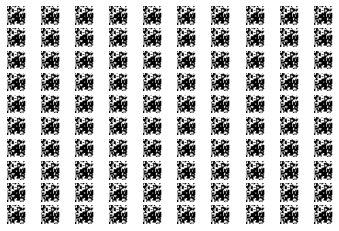

In [6]:
#######################
#####CALL GENERATE#####
#######################

# load model
model = load_model("C:\\_Thesis\\VirtualEnv\\_models\\_AC-GAN\\model_93700.h5")
latent_dim = 100
n_examples = 100 # must be a square
n_class = 7 # sneaker
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
X = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
# plot the result
show_plot(X, n_examples)